In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install category_encoders


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from imblearn.combine import SMOTEENN

df_customer=pd.read_csv('customer_dataset.csv')
df_transactions=pd.read_csv('updated_fraud_transactions.csv')

df_transactions.dtypes


,0
Transaction ID,object
Timestamp,object
Sender Account ID,int64
Transaction Type,object
IN_OUT,object
Amount,float64
Recipient Bank,object
Fraud,int64


In [3]:
df = df_transactions.merge(df_customer[['Customer ID', 'Device Count','Location','Account Type','Age']], left_on='Sender Account ID', right_on='Customer ID')
df.dtypes

,0
Transaction ID,object
Timestamp,object
Sender Account ID,int64
Transaction Type,object
IN_OUT,object
Amount,float64
Recipient Bank,object
Fraud,int64
Customer ID,int64
Device Count,int64


In [4]:
#Encoding
df = pd.get_dummies(df, columns=['IN_OUT', 'Account Type','Transaction Type'], drop_first=True)
label_encoder = LabelEncoder()

df['Recipient Bank'] = label_encoder.fit_transform(df['Recipient Bank'])

district_map = {
    'Colombo': 1,       # Western Province
    'Gampaha': 2,       # Western Province
    'Kalutara': 3,      # Western Province
    'Kandy': 4,         # Central Province
    'Matale': 5,        # Central Province
    'Nuwara Eliya': 6,  # Central Province
    'Galle': 7,         # Southern Province
    'Matara': 8,        # Southern Province
    'Hambantota': 9,    # Southern Province
    'Jaffna': 10,       # Northern Province
    'Kilinochchi': 11,  # Northern Province
    'Mannar': 12,       # Northern Province
    'Vavuniya': 13,     # Northern Province
    'Mullaitivu': 14,   # Northern Province
    'Trincomalee': 15,  # Eastern Province
    'Batticaloa': 16,   # Eastern Province
    'Ampara': 17,       # Eastern Province
    'Kurunegala': 18,   # North Western Province
    'Puttalam': 19,     # North Western Province
    'Anuradhapura': 20, # North Central Province
    'Polonnaruwa': 21,  # North Central Province
    'Badulla': 22,      # Uva Province
    'Monaragala': 23,   # Uva Province
    'Ratnapura': 24,    # Sabaragamuwa Province
    'Kegalle': 25       # Sabaragamuwa Province
}

# Step 2: Apply the district map to the 'Location' column in your dataframe df
df['Location'] = df['Location'].map(district_map)

In [5]:

# Column Scaling
# Min-Max scaling for Age
df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())
cols_to_standardize = ['Amount']
scaler = StandardScaler()
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])



In [6]:
#Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour

df['day_of_week'] = df['Timestamp'].dt.day_name()
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

monthly_customer_features = df.groupby(['Customer ID', 'Year', 'Month']).agg(
    Monthly_Transaction_Count=('Transaction ID', 'count'),
    Monthly_Average_Transaction_Amount=('Amount', 'mean')
).reset_index()

# Merge the new monthly features back into the original DataFrame
df = df.merge(monthly_customer_features, on=['Customer ID', 'Year', 'Month'], how='left')

# Transaction Amount Ratio
df['Transaction Amount Ratio'] = df['Amount'] / df['Monthly_Average_Transaction_Amount']


#Transaction Type Based Features
#transaction_type_count = df.groupby('Customer ID')['Transaction Type'].nunique().reset_index()
#transaction_type_count.columns = ['Customer ID', 'Transaction Type Count']
# Merge the counts back into the original DataFrame
#df = df.merge(transaction_type_count, on='Customer ID', how='left')
# Calculate the proportion of each transaction type relative to the total transactions for each customer
#df['Transaction Type Proportion'] = df.groupby(['Customer ID', 'Transaction Type'])['Transaction Type'].transform('count') / df['Transaction_Count']


#Device Count Levels
bins = [0, 3, 7, 11]
labels = [1, 2, 3]  # Low: 1, Medium: 2, High: 3
df['Device Count Category'] = pd.cut(df['Device Count'], bins=bins, labels=labels, right=True)
df['Device Count Category'] = df['Device Count Category'].astype(int)
df.head()

#Time Since Last Transaction:
df['Last_Transaction'] = df.groupby('Sender Account ID')['Timestamp'].shift(1)
df['Time_Since_Last_Transaction'] = (df['Timestamp'] - df['Last_Transaction']).dt.total_seconds() / 60


In [7]:
df.drop(columns=['Transaction ID', 'Timestamp','Customer ID','Sender Account ID','Device Count','Last_Transaction','day_of_week'], inplace=True)
df.head()


,Amount,Recipient Bank,Fraud,Location,Age,IN_OUT_Out,Account Type_Fixed Deposit,Account Type_Savings,Transaction Type_Debit,Transaction Type_Payment,Transaction Type_Transfer,Year,Month,Day,Hour,Monthly_Transaction_Count,Monthly_Average_Transaction_Amount,Transaction Amount Ratio,Device Count Category,Time_Since_Last_Transaction
0,1.105813,4,0,16,0.661290,False,False,True,False,False,True,2023,8,14,8,79,-0.224165,-4.933040,3,NaN
1,-0.120951,1,0,8,0.677419,False,False,True,False,False,True,2023,12,4,12,81,0.137635,-0.878785,3,NaN
2,1.030623,8,0,10,0.741935,False,False,False,False,False,False,2023,7,9,23,89,-0.050652,-20.346942,3,NaN
3,-0.524232,5,0,4,0.677419,False,False,False,False,False,False,2023,6,26,7,80,0.058702,-8.930337,1,NaN
4,0.662351,4,0,24,0.290323,True,False,True,True,False,False,2023,9,28,2,83,0.009588,69.084147,2,NaN


In [8]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Amount                              100000 non-null  float64
 1   Recipient Bank                      100000 non-null  int64  
 2   Fraud                               100000 non-null  int64  
 3   Location                            100000 non-null  int64  
 4   Age                                 100000 non-null  float64
 5   IN_OUT_Out                          100000 non-null  bool   
 6   Account Type_Fixed Deposit          100000 non-null  bool   
 7   Account Type_Savings                100000 non-null  bool   
 8   Transaction Type_Debit              100000 non-null  bool   
 9   Transaction Type_Payment            100000 non-null  bool   
 10  Transaction Type_Transfer           100000 non-null  bool   
 11  Year                       

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Step 2: Reshape the data to 2D array for the imputer
time_since_last_transaction = df[['Time_Since_Last_Transaction']]

# Step 3: Fit and transform the column
imputed_values = imputer.fit_transform(time_since_last_transaction)

# Step 4: Assign the imputed values back to the DataFrame
df['Time_Since_Last_Transaction'] = imputed_values

In [10]:
#Data Balancing
df= df.dropna(subset=['Fraud'])
X = df.drop(columns=['Fraud'])
y = df['Fraud']

smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X, y)

print(f"Number of Fraudulent Transactions: {sum(y_smoteenn == 1)}")
print(f"Number of Non-Fraudulent Transactions: {sum(y_smoteenn == 0)}")

Number of Fraudulent Transactions: 47590
Number of Non-Fraudulent Transactions: 41820


Feature Selection using FDE (Feature Discriminability Evaluation)

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42)

In [13]:
# Train a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display the scores
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Rank features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_df)

Feature Importances:
                               Feature  Importance
0                               Amount    0.178508
9            Transaction Type_Transfer    0.131501
15  Monthly_Average_Transaction_Amount    0.108066
3                                  Age    0.065554
2                             Location    0.060707
5           Account Type_Fixed Deposit    0.057559
16            Transaction Amount Ratio    0.055976
6                 Account Type_Savings    0.055340
1                       Recipient Bank    0.042871
13                                Hour    0.037262
18         Time_Since_Last_Transaction    0.033634
17               Device Count Category    0.031884
14           Monthly_Transaction_Count    0.026271
12                                 Day    0.025291
8             Transaction Type_Payment    0.025108
7               Transaction Type_Debit    0.021968
4                           IN_OUT_Out    0.021486
11                               Month    0.021014
10        

<ipython-input-15-2aa7c7953317>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: Wh

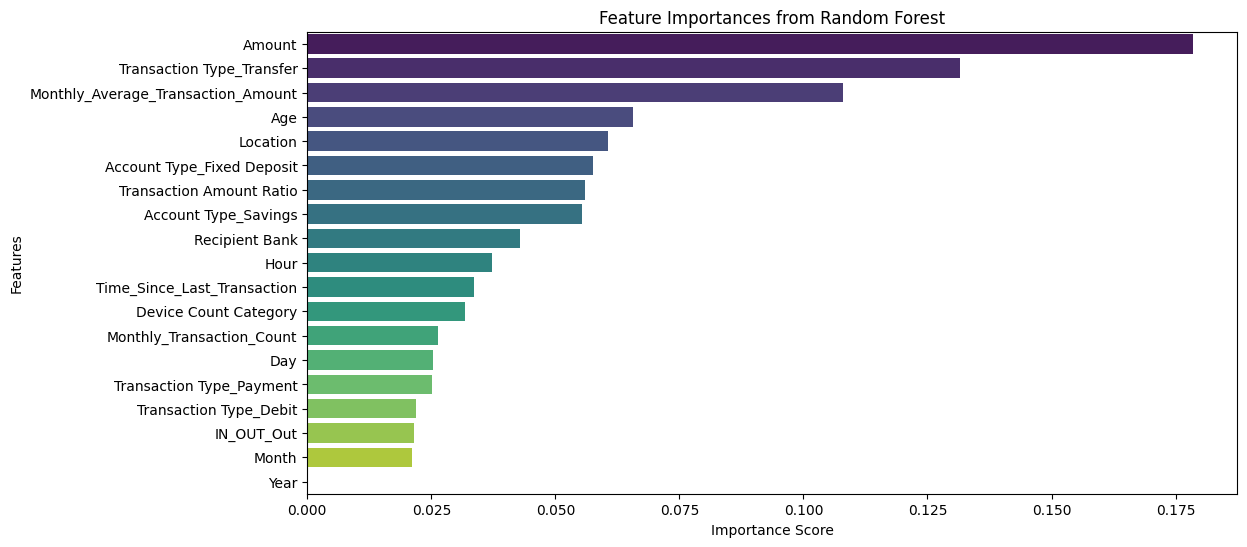

In [15]:
# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [16]:

# Evaluate model performance
y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      8406
           1       0.97      0.95      0.96      9476

    accuracy                           0.96     17882
   macro avg       0.96      0.96      0.96     17882
weighted avg       0.96      0.96      0.96     17882

Random Forest Confusion Matrix:
[[8172  234]
 [ 477 8999]]
Random Forest ROC-AUC Score: 0.9932


In [17]:
rf2 = RandomForestClassifier(random_state=42)

#Cross Validation
k = 5  # Number of folds
cv_scores = cross_val_score(rf2, X_train, y_train, cv=k, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")


rf2.fit(X_train, y_train)

y_pred = rf2.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Cross-Validation F1 Scores: [0.962391   0.95933985 0.95692246 0.96213986 0.95881098]
Mean F1 Score: 0.9599208324983712
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      8406
           1       0.97      0.95      0.96      9476

    accuracy                           0.96     17882
   macro avg       0.96      0.96      0.96     17882
weighted avg       0.96      0.96      0.96     17882



After Feature Selection

In [18]:
# Select the top 10 most important features
top_features = feature_importances_df.nlargest(10, 'Importance')['Feature']

#Trainingset with only top 10 features
X_train_top = X_train[top_features]


print("Top 10 Features:")
print(top_features)

Top 10 Features:
0                                 Amount
9              Transaction Type_Transfer
15    Monthly_Average_Transaction_Amount
3                                    Age
2                               Location
5             Account Type_Fixed Deposit
16              Transaction Amount Ratio
6                   Account Type_Savings
1                         Recipient Bank
13                                  Hour
Name: Feature, dtype: object


In [19]:
warnings.filterwarnings("ignore")
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}


k = 5
for model_name, model in models.items():

    cv_scores = cross_val_score(model, X_train_top, y_train, cv=k, scoring='f1')
    print(f"{model_name} Cross-Validation F1 Scores: {cv_scores}")
    print(f"{model_name} Mean F1 Score: {cv_scores.mean()}\n")

    # Fit the model on the full training set using the top 10 features
    model.fit(X_train_top, y_train)


    y_pred = model.predict(X_test[top_features])  # Use the top features for prediction
    print(f"{model_name} Classification Report on Test Set:")
    print(classification_report(y_test, y_pred))

Random Forest Cross-Validation F1 Scores: [0.94903782 0.94938133 0.94656387 0.95198358 0.94660742]
Random Forest Mean F1 Score: 0.9487148023920347

Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8406
           1       0.96      0.94      0.95      9476

    accuracy                           0.95     17882
   macro avg       0.95      0.95      0.95     17882
weighted avg       0.95      0.95      0.95     17882

XGBoost Cross-Validation F1 Scores: [0.96379127 0.96537976 0.96554023 0.96550354 0.96401919]
XGBoost Mean F1 Score: 0.9648467968308829

XGBoost Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      8406
           1       0.98      0.95      0.97      9476

    accuracy                           0.97     17882
   macro avg       0.97      0.97      0.97     17882
weighted avg       0.97  

With Hyperparameter Tuning

In [ ]:
warnings.filterwarnings("ignore")
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, scale_pos_weight=13,max_depth=15,learning_rate=0.05,n_estimators=3000,reg_lambda=3, reg_alpha=3,
    random_state=42,
    eval_metric=['logloss', 'auc']),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}


k = 5
for model_name, model in models.items():

    cv_scores = cross_val_score(model, X_train_top, y_train, cv=k, scoring='f1')
    print(f"{model_name} Cross-Validation F1 Scores: {cv_scores}")
    print(f"{model_name} Mean F1 Score: {cv_scores.mean()}\n")

    # Fit the model on the full training set using the top 10 features
    model.fit(X_train_top, y_train)


    y_pred = model.predict(X_test[top_features])  # Use the top features for prediction
    print(f"{model_name} Classification Report on Test Set:")
    print(classification_report(y_test, y_pred))

Random Forest Cross-Validation F1 Scores: [0.94903782 0.94938133 0.94656387 0.95198358 0.94660742]
Random Forest Mean F1 Score: 0.9487148023920347

Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8406
           1       0.96      0.94      0.95      9476

    accuracy                           0.95     17882
   macro avg       0.95      0.95      0.95     17882
weighted avg       0.95      0.95      0.95     17882

XGBoost Cross-Validation F1 Scores: [0.96553966 0.96411654 0.96406718 0.96435053 0.96252107]
XGBoost Mean F1 Score: 0.9641189972153723



In [ ]:
# Display the cleaned data
print(df.head())

# Save the cleaned data
df.to_csv('cleaned_data.csv', index=False)
print("Cleaned data saved to 'cleaned_data_final.csv'.")